In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [176]:
import shutil

In [16]:
import pickle
from PIL import Image
import numpy as np

In [109]:
from einops import rearrange
from net import WaterNet
from pathlib import Path
from IPython.display import display

In [170]:
from tqdm import tqdm

In [141]:
import matplotlib.pyplot as plt
%matplotlib inline

## Load weights

In [3]:
waternet = WaterNet()

In [5]:
with open("../assets/waternet-exported-state-dict.pkl", "rb") as f:
    exported_sd = pickle.load(f)

In [7]:
waternet.load_state_dict(exported_sd)

<All keys matched successfully>

In [11]:
torch.save(waternet.state_dict(), "../assets/waternet-exported-state-dict.pt")

## Test on sample image(s)

In [90]:
def im2ten(imdir):
    return torch.from_numpy(np.array(Image.open(imdir))) / 255

In [98]:
def ten2im(ten):
    # CHW
    arr = ten.detach().numpy()
    arr = np.clip(arr, 0, 1)
    arr = (arr * 255).astype(np.uint8)
    arr = rearrange(arr, "c h w -> h w c")
    return Image.fromarray(arr)

In [155]:
def ten2arr(ten):
    # CHW
    arr = ten.detach().numpy()
    arr = np.clip(arr, 0, 1)
    arr = (arr * 255).astype(np.uint8)
    arr = rearrange(arr, "c h w -> h w c")
    return arr

In [168]:
rawdir = Path("../data/bundled/input_train/")
wbdir = Path("../data/bundled/input_wb_train/")
cedir = Path("../data/bundled/input_ce_train/")
gcdir = Path("../data/bundled/input_gc_train/")
gtdir = Path("../data/bundled/gt_train/")

In [157]:
imname = "10_img_.jpg"

In [158]:
raw = im2ten(rawdir / imname)
wb = im2ten(wbdir / imname)
ce = im2ten(cedir / imname)
gc = im2ten(gcdir / imname)

In [159]:
raw_ten = rearrange(raw, "h w c -> 1 c h w")
wb_ten = rearrange(wb, "h w c -> 1 c h w")
ce_ten = rearrange(ce, "h w c -> 1 c h w")
gc_ten = rearrange(gc, "h w c -> 1 c h w")

In [160]:
out = waternet(raw_ten, wb_ten, ce_ten, gc_ten)
# torch.Size([1, 3, 112, 112])

In [164]:
out_im = Image.fromarray(ten2arr(out[0]))

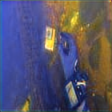

In [165]:
display(out_im)

In [166]:
gt = Image.open(gtdir / imname)

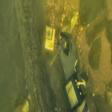

In [167]:
display(gt)

### Run on all

In [182]:
rawdir = Path("../data/bundled/input_test/")
wbdir = Path("../data/bundled/input_wb_test/")
cedir = Path("../data/bundled/input_ce_test/")
gcdir = Path("../data/bundled/input_gc_test/")
gtdir = Path("../data/bundled/gt_test/")

In [183]:
list_of_imnames = sorted(
    [i.name for i in rawdir.glob("*")], 
    key=lambda x: int(x.split("_")[0])
)

In [184]:
outdir = Path("../output/test-exported-model/")

In [185]:
if outdir.exists():
    shutil.rmtree(outdir)

In [186]:
if not outdir.exists():
    outdir.mkdir(parents=True)

In [187]:
for imname in tqdm(list_of_imnames, dynamic_ncols=True):   
    raw = im2ten(rawdir / imname)
    wb = im2ten(wbdir / imname)
    ce = im2ten(cedir / imname)
    gc = im2ten(gcdir / imname)
    
    raw_ten = rearrange(raw, "h w c -> 1 c h w")
    wb_ten = rearrange(wb, "h w c -> 1 c h w")
    ce_ten = rearrange(ce, "h w c -> 1 c h w")
    gc_ten = rearrange(gc, "h w c -> 1 c h w")
    
    out = waternet(raw_ten, wb_ten, ce_ten, gc_ten)
    out_im = ten2arr(out[0])
    
    gt = np.array(Image.open(gtdir / imname))
    
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].imshow(out_im)
    ax[1].imshow(gt)
    
    ax[0].set_title("Predicted")
    ax[1].set_title("Actual")
    
    fig.suptitle(imname)
    
    plt.tight_layout()
    
    plt.savefig(outdir / f"{imname}", bbox_inches="tight", facecolor="white")
    
    plt.close(fig)

100%|███████████████████████████████████████████████████████████████████████████████████| 90/90 [00:27<00:00,  3.29it/s]
